In [1]:
import numpy as np
import sys
sys.path.insert(0, "../")
from argparse import Namespace
import os
os.chdir('C:/Users/Lorenz/PycharmProjects/flatland')
import torch
import flatland_starter_kit_master
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import TreeObsForRailEnv

tree_observation = TreeObsForRailEnv(max_depth=2)
observation_tree_depth = 2
observation_radius = 10

env = RailEnv(
        width=35,
        height=35,
        rail_generator=sparse_rail_generator(
            max_num_cities=2,
            grid_mode=False,
            max_rails_between_cities=2,
            max_rail_pairs_in_city=2
        ),
        line_generator=sparse_line_generator(),
        number_of_agents=1,
        obs_builder_object=tree_observation
    )

os.chdir('C:/Users/Lorenz/PycharmProjects/flatland/flatland_starter_kit_master/baselines')
from reinforcement_learning.dddqn_policy import DDDQNPolicy
from utils.observation_utils import normalize_observation

n_features_per_node = env.obs_builder.observation_dim
n_nodes = 0
for i in range(observation_tree_depth + 1):
    n_nodes += np.power(4, i)
state_size = n_features_per_node * n_nodes
policy = DDDQNPolicy(state_size, 5, Namespace(**{'use_gpu': False}), evaluation_mode=True)
policy.qnetwork_local = torch.load('./checkpoints/single-2500.pth').to(policy.device)

In [2]:
import PIL
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output


def render_env(env, renderer, wait=True):
    
    env_renderer = renderer
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)
    
def run_episode(env):
    renderer = RenderTool(env, gl="PILSVG")
    obs, info = env.reset()
    agent_obs = [None]
    agent_prev_obs = [None]
    
    score = 0
    actions = dict()

    for step in range(1000):
        actions=dict()
        for agent_handle, agent in enumerate(env.agents):
            if obs[agent_handle]:
                agent_obs[agent_handle] = normalize_observation(obs[agent_handle], observation_tree_depth, observation_radius=observation_radius)
                agent_prev_obs[agent_handle] = agent_obs[agent_handle].copy()
            action = policy.act(agent_obs[agent_handle])
            actions.update({agent_handle: action})
            print('Agent in state {} with earliest departure time {} taking action {}'.format(agent.state, agent.earliest_departure, action))
        next_observations, all_rewards, dones, info = env.step(actions)
        observations = next_observations
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]
            
        render_env(env, renderer)
        print('Timestep {}, total score = {}'.format(step, score))

        if dones['__all__']:
            print('All done! It took {} timesteps and the final score was {}.'.format(step, score))
            return

    print("Episode didn't finish after 1000 timesteps. The final score was {}.".format(score))

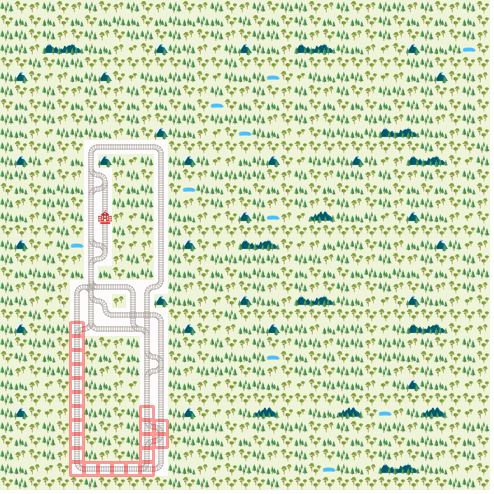

Timestep 52, total score = -84
All done! It took 52 timesteps and the final score was -84.


In [3]:
run_episode(env)